## Setting Up the API Connection and Fetching Evaluation Questions

In this section, we test the evaluation API and implement a function to retrieve all available questions. I use a simple `GET` request to obtain the test dataset and then display a random sample to understand the structure of each question object.

In [1]:
import requests
import random
import json

BASE_URL = "https://agents-course-unit4-scoring.hf.space"

def fetch_questions():
    response = requests.get(f"{BASE_URL}/questions", headers={"accept": "application/json"})
    if response.ok:
        return response.json()
    else:
        print("Failed to fetch questions:", response.status_code)
        return []

# Get the questions
questions = fetch_questions()

# Print the first one
if questions:
    # random.seed(42)
    random_samples = random.sample(questions, 1)

    json_str = json.dumps(random_samples, indent=4)    
    print(json_str)

[
    {
        "task_id": "cabe07ed-9eca-40ea-8ead-410ef5e83f91",
        "question": "What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?",
        "Level": "1",
        "file_name": ""
    }
]


## Identifying Questions with Associated Resource Files

Some function might include additional resource files, such as documents or datasets. These files are necessary for answering or evaluating the task correctly. Here, I filter the list of questions in the dataset that requires downloading external resource.


In [2]:
for q in questions:
    v = list(q.values())
    if bool(v[3]):
        print(f"Task ID: {v[0]}")
        print(f"File: {v[3]}")
        print()

Task ID: cca530fc-4052-43b2-b130-b30968d8aa44
File: cca530fc-4052-43b2-b130-b30968d8aa44.png

Task ID: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3
File: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3

Task ID: f918266a-b3e0-4914-865d-4faa564f1aef
File: f918266a-b3e0-4914-865d-4faa564f1aef.py

Task ID: 1f975693-876d-457b-a649-393859e79bf3
File: 1f975693-876d-457b-a649-393859e79bf3.mp3

Task ID: 7bd855d8-463d-4ed5-93ca-5fe35145f733
File: 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx



## Downloading Associated Files for Relevant Tasks

Now that we know which questions include external files, I implement a function to download those resources. This ensures that we have all necessary data locally before we attempt to generate or score responses. I create a `resources/` directory and save each file using its original filename.

In [3]:
def download_file(task_id, filename=None):
    response = requests.get(f"{BASE_URL}/files/{task_id}")
    if response.ok:
        filename = filename or f"{task_id}.zip"
        filename = f"resources/{filename}"
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Downloaded file for task {task_id} -> {filename}")
    else:
        print(f"No file found or failed to download for task {task_id}")

for q in questions:
    v = list(q.values())
    if bool(v[3]):
        task_id = v[0]
        file = v[3]
        print(f"Task ID: {task_id}")
        print(f"File: {file}")

        download_file(task_id, file)
        print()

Task ID: cca530fc-4052-43b2-b130-b30968d8aa44
File: cca530fc-4052-43b2-b130-b30968d8aa44.png
Downloaded file for task cca530fc-4052-43b2-b130-b30968d8aa44 -> resources/cca530fc-4052-43b2-b130-b30968d8aa44.png

Task ID: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3
File: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
Downloaded file for task 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3 -> resources/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3

Task ID: f918266a-b3e0-4914-865d-4faa564f1aef
File: f918266a-b3e0-4914-865d-4faa564f1aef.py
Downloaded file for task f918266a-b3e0-4914-865d-4faa564f1aef -> resources/f918266a-b3e0-4914-865d-4faa564f1aef.py

Task ID: 1f975693-876d-457b-a649-393859e79bf3
File: 1f975693-876d-457b-a649-393859e79bf3.mp3
Downloaded file for task 1f975693-876d-457b-a649-393859e79bf3 -> resources/1f975693-876d-457b-a649-393859e79bf3.mp3

Task ID: 7bd855d8-463d-4ed5-93ca-5fe35145f733
File: 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
Downloaded file for task 7bd855d8-463d-4ed5-93ca-5fe35145f733 -> res

## Exploring the API’s Random Question Endpoint

In addition to fetching the full set of questions, the API also offers an endpoint for retrieving a random question. This is useful for sampling tasks dynamically during development or testing, without processing the entire dataset.

In [4]:
def fetch_random_question():
    response = requests.get(f"{BASE_URL}/random-question", headers={"accept": "application/json"})
    if response.ok:
        return response.json()
    else:
        print("Failed to fetch questions:", response.status_code)
        return []

res = fetch_random_question()
json_str = json.dumps(random_samples, indent=4)    
print(json_str)

[
    {
        "task_id": "cabe07ed-9eca-40ea-8ead-410ef5e83f91",
        "question": "What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?",
        "Level": "1",
        "file_name": ""
    }
]


In [5]:
len(questions)

20

## Downloading the Training Set

To effectively develop and test our agent, we need access to a set of pre-annotated tasks with corresponding gold answers. This "training set" provides labeled data that can be used to analyze model behavior, measure performance, or fine-tune the agent. Let's download the full training dataset from the API and examine its structure.

In [6]:
from datasets import load_dataset

dataset = load_dataset("gaia-benchmark/GAIA", name="2023_all", split="validation")

In [7]:
print("Dataset info:")
print(f" ├── Validation split: {len(dataset)} samples")

sample = random.choice(dataset.to_list())

# Pretty print sample
line = "─" * 60
print(line)
print(f"Task ID     : {sample['task_id']}")
print(f"Level       : {sample['Level']}")
print(f"Question    : {sample['Question']}")
print(f"Answer      : {sample['Final answer']}")
print("Annotator Metadata:")
print(" ├── Steps:")
for step in sample['Annotator Metadata']['Steps'].split('\n'):
    print(f" │    ├── {step}")
print(f" ├── Number of steps : {sample['Annotator Metadata']['Number of steps']}")
print(f" ├── Duration        : {sample['Annotator Metadata']['How long did this take?']}")
print(f" ├── Tools used:")
for tool in sample['Annotator Metadata']['Tools'].split('\n'):
    print(f" │    ├── {tool}")
print(f" └── Number of tools : {sample['Annotator Metadata']['Number of tools']}")
print(line)

Dataset info:
 ├── Validation split: 165 samples
────────────────────────────────────────────────────────────
Task ID     : 65afbc8a-89ca-4ad5-8d62-355bb401f61d
Level       : 1
Question    : You are given this Excel file as a map. You start on the START cell and move toward the END cell. You are allowed to move two cells per turn, and you may move up, down, left, or right. You may not move fewer than two cells, and you may not move backward. You must avoid moving onto any blue cells. On the eleventh turn, what is the 6-digit hex code (without prefix) of the color of the cell where you land after moving?
Answer      : F478A7
Annotator Metadata:
 ├── Steps:
 │    ├── 1. Opened Map.xlsx.
 │    ├── 2. Counted 11 turns of 2 spaces each (22 spaces) along the path of non-blue cells.
 │    ├── 3. Opened cell formatting for the cell.
 │    ├── 4. Clicked the "Fill" tab.
 │    ├── 5. Clicked "More Colors..."
 │    ├── 6. Noted the hex code of the color.
 ├── Number of steps : 6
 ├── Duration    

## Analyzing Tool Usage Across Annotated Tasks

Before designing an agent capable of solving GAIA tasks, it's helpful to understand the types of tools that are required to fulfill the tasks. This insight informs us about the functional capabilities the agent may need, such as web browsing, calculation, or image recognition.

Below, I extract and summarize tool usage statistics from the "Annotator Metadata" field of each annotated sample in the dataset. By standardizing the tool names and counting their frequencies, we can identify which tools were most commonly required and, by extension, which functionalities are essential for agent reasoning and task completion.

This analysis helps prioritize which tool integrations should be implemented or optimized in the agent. For example, if most tasks rely on web search or calculators, these capabilities should be central to the agent's design and evaluation loop.

In [20]:
from collections import Counter, OrderedDict

def extract_gaia_tool_stats(dataset):
    tools = []
    for sample in dataset:
        raw_tools = sample.get("Annotator Metadata", {}).get("Tools", "")
        for tool in raw_tools.split('\n'):
            tool = tool[2:].strip().lower()  # remove bullet/indentation
            if tool.startswith("("):        # handles: "(1) Wikipedia"
                tool = tool[tool.find(")") + 1:].strip()
            if tool:  # skip empty entries
                tools.append(tool)

    # Count and sort tools by frequency
    tools_counter = OrderedDict(sorted(Counter(tools).items(), key=lambda x: x[1], reverse=True))

    return tools_counter

tools_counter = extract_gaia_tool_stats(dataset)
print(tools)

OrderedDict([('web browser', 107), ('search engine', 101), ('calculator', 34), ('image recognition tools', 12), ('ne', 9), ('pdf access', 7), ('pdf viewer', 7), ('a web browser', 7), ('a search engine', 7), ('microsoft excel', 5), ('image recognition', 5), ('a calculator', 5), ('ocr', 4), ('python', 3), ('video recognition tools', 3), ('microsoft excel / google sheets', 3), ('excel', 3), ('color recognition', 3), ('excel file access', 3), ('access to wikipedia', 3), ('image recognition/ocr', 3), ('a file interface', 3), ('a web browser.', 2), ('a search engine.', 2), ('file handling', 2), ('a speech-to-text tool', 2), ('audio capability', 2), ('image recognition tools (to identify and parse a figure with three axes)', 1), ('unlambda compiler (optional)', 1), ('a calculator.', 1), ('google search', 1), ('jsonld file access', 1), ('video parsing', 1), ('python compiler', 1), ('word document access', 1), ('tool to extract text from images', 1), ('a word reversal tool / script', 1), ('coun

## Grouping Redundant Tools with Semantic Clustering

The raw tool frequency data extracted previously includes many redundant or inconsistent tool names, such as `"web browser"`, `"a web browser"`, and `"b browser"`, which all refer to essentially the same capability. To clean this data and better understand the agent capabilities required, we group semantically similar tools using sentence embeddings and clustering.

In this step, we use a pretrained sentence transformer (all-MiniLM-L6-v2) to embed each tool name into a vector space. Then, we apply agglomerative clustering based on cosine distance to group tool names that are semantically close to each other. For each cluster, we aggregate the total count of tool occurrences and print a sorted summary.

This clustering helps us identify broader tool categories (e.g., search, calculation, image parsing) and reduces noise from naming inconsistencies in the annotations. These grouped categories will inform how we define and prioritize tool implementations for our LangGraph agent.

In [23]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
import numpy as np

def group_similar_tools(tools_counter, threshold=1.5):
    """
    Group similar tool names based on semantic similarity using Agglomerative Clustering.
    Returns dict {canonical_label: [tool_names...]} and {canonical_label: total_count}.
    """
    tool_names = list(tools_counter.keys())
    counts = list(tools_counter.values())

    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(tool_names)

    # Perform clustering with cosine distance
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=threshold,
        metric='cosine',        # <- Fix here
        linkage='average'
    )
    labels = clustering.fit_predict(embeddings)

    # Group by cluster
    clusters = defaultdict(list)
    cluster_counts = defaultdict(int)

    for i, label in enumerate(labels):
        clusters[label].append(tool_names[i])
        cluster_counts[label] += counts[i]

    # Build output
    grouped = {
        ", ".join(cluster): count
        for cluster, count in zip(clusters.values(), cluster_counts.values())
    }

    # Sort by count
    sorted_grouped = dict(sorted(grouped.items(), key=lambda x: x[1], reverse=True))

    return sorted_grouped


In [43]:
grouped_tools = group_similar_tools(tools_counter, threshold=0.7)
for label, count in grouped_tools.items():
    print(f"  ├── [{label}] → total: {count}")

  ├── [web browser, search engine, a web browser, a search engine, access to wikipedia, a web browser., a search engine., google search, access to the internet archive, web.archive.org, b browser, youtube player, access to youtube, access to academic journal websites, wikipedia, youtube] → total: 237
  ├── [calculator, a calculator, a calculator., counter, calculator (or use excel), computer algebra system, calculator (or ability to count), calculator or counting function] → total: 45
  ├── [image recognition tools, image recognition, ocr, video recognition tools, color recognition, image recognition/ocr, audio capability, image recognition tools (to identify and parse a figure with three axes), video parsing, gif parsing tools, video processing software, audio processing software, computer vision, image recognition and processing tools, computer vision or ocr, image search tools, video capability, image processing tools, age recognition software] → total: 44
  ├── [pdf access, pdf vie

## Selecting Canonical Labels for Tool Clusters

After grouping redundant tools into semantically similar clusters, we now need to select a canonical label for each cluster. A canonical label serves as the representative name for each tool group; for example, `"search engine"` might represent all variations of internet search tools like `"web browser"`, `"google search"`, or `"access to wikipedia"`.

To do this, we again use a sentence transformer to compute embeddings for each tool name within a cluster. Then, we calculate the centroid vector (average embedding) for the cluster and choose the tool name whose embedding is closest to the centroid in terms of cosine similarity. This ensures that the canonical label is the most semantically central or neutral name among the cluster’s tools.

The result is:

- canonical_mapping: a dictionary mapping each original tool name to its canonical representative.
- canonical_counts: a count of how many times each canonical tool appears, aggregating across all merged names.

This mapping simplifies the toolset and creates a clean, standardized vocabulary for downstream tool implementation.

In [44]:
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict
import numpy as np

def get_nlp_canonical_mapping(grouped_clusters, original_counts):
    """
    Uses sentence embeddings to find the most semantically central (canonical) label in each cluster.
    
    Returns:
        canonical_mapping: dict {original_tool → canonical_label}
        canonical_counts: dict {canonical_label → total_count}
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")
    
    canonical_mapping = {}
    canonical_counts = {}

    for cluster_label, count in grouped_clusters.items():
        tools = [t.strip() for t in cluster_label.split(',')]
        embeddings = model.encode(tools)

        # Compute centroid of embeddings
        centroid = np.mean(embeddings, axis=0)

        # Compute cosine similarities to centroid
        sims = util.cos_sim(centroid, embeddings)[0]

        # Select tool closest to centroid
        canonical_idx = sims.argmax().item()
        canonical_tool = tools[canonical_idx]

        # Map all tools in cluster to canonical
        for tool in tools:
            canonical_mapping[tool] = canonical_tool
        canonical_counts[canonical_tool] = count

    return canonical_mapping, canonical_counts

canonical_mapping, canonical_counts = get_nlp_canonical_mapping(grouped_tools, tools_counter)


In [45]:
set(canonical_mapping.values())

{'a calculator',
 'a speech-to-text tool',
 'access to google maps',
 'bablyonian cuniform -> arabic legend',
 'bass note data',
 'image recognition tools',
 'jsonld file access',
 'markdown',
 'ne',
 'pdf access',
 'python compiler',
 "rubik's cube model",
 'search engine',
 'spreadsheet editor',
 'unlambda compiler (optional)'}

## Implementing Canonical Tools for the Agent

Now that we have identified a canonical set of tools based on the GAIA dataset, the next step is to implement each tool programmatically so the agent can invoke them when needed. These tools will be wrapped as LangChain-compatible `@tool` functions, allowing LangGraph to automatically call the appropriate function when the agent determines that a tool is required to complete a task.

Each tool is designed to match one of the canonical labels we derived earlier.

### Calculator Tool

The calculator tool is a fundamental utility used to evaluate arithmetic expressions. In the GAIA dataset, annotators frequently used a calculator to perform basic numerical operations such as addition, multiplication, and division.

We implement the calculator as a secure wrapper around Python’s `eval()` function, disabling built-in functions to reduce the risk of arbitrary code execution. The tool takes a string input like `"10 / (2 + 3)"` and returns the computed result as a string.

In [47]:
from langchain_core.tools import tool

@tool
def calculator(expression: str) -> str:
    """Evaluates a math expression like '2 + 2 * 3'."""
    try:
        return str(eval(expression, {"__builtins__": {}}))
    except Exception as e:
        return f"Error: {str(e)}"

# Test
print(calculator.invoke("10 / (2 + 3)"))

2.0


### Web Browser Tool

While many GAIA tasks require factual recall, a significant portion also rely on up-to-date information or content that resides online. To simulate this capability within the agent, we implement a web browser tool.

This tool mimics how a human might look something up on the internet: by issuing a query to a search engine and scanning the contents of the results. We use the `TavilySearchResults` wrapper from the LangChain community tools, which provides a simple API to retrieve relevant web snippets from trusted sources.

This tool is especially useful for fact-checking, resolving ambiguous context, or accessing specific examples or definitions that are not directly encoded in the model’s training data.

The tool returns a list of search results, each with a title, URL, content preview, and relevance score. This functionality enables the agent to incorporate recent or external knowledge into its responses, enhancing its ability to reason about real-world queries just as a human would.

In [48]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Basic browsing simulation (search + preview)
@tool
def web_browser(query: str) -> str:
    """Simulates a web browser by performing a search and returning relevant page content."""
    tavily = TavilySearchResults()
    return tavily.run(query)

result = web_browser.invoke("best football player of all time")
print(result)


[{'title': 'Who are the consensus top 5 greatest footballers of all time and why?', 'url': 'https://www.reddit.com/r/SoccerNoobs/comments/1ia0b7f/who_are_the_consensus_top_5_greatest_footballers/', 'content': 'Lionel Messi, Cristiano Ronaldo, Pele and Diego Maradona are generally viewed as the top four (not necessarily in that order).', 'score': 0.8215175}, {'title': "The IFFHS proclaims Messi as 'the best of all time'... and there is ...", 'url': 'https://www.marca.com/en/football/2025/05/19/682af86122601dea4f8b4573.html', 'content': "m**essi is the number one in history, at least for the International Federation of Football History and Statistics (IFFHS),** which last weekend drew up its ranking of the 10 best players of all time. And of course, the controversy has erupted in all forums in a discussion that is very footballing and lawful [...] The International Federation of Football History and Statistics published its own ranking\n\n![Image 3: The IFFHS proclaims Messi as 'the best

### Python Code Execution Tool

In some GAIA tasks, reasoning involves more than just retrieving facts, it requires applying logic or performing step-by-step calculations. While the calculator tool helps with simple expressions, it lacks the flexibility for more complex operations like loops, conditionals, or custom logic.

To address this, we introduce a Python code execution tool, which allows the agent to safely execute small Python snippets inside a sandboxed environment. This is particularly useful for:

- Aggregating values (e.g., sums, averages)
- Simulating algorithmic steps
- Validating logic or patterns
- Parsing and transforming data


In [49]:
@tool
def execute_python(code: str) -> str:
    """Compiles and executes a Python snippet (sandboxed)."""
    try:
        local_vars = {}
        exec(code, {}, local_vars)
        return str(local_vars.get("result", "[Executed]"))
    except Exception as e:
        return f"Error: {str(e)}"

# Test
print(execute_python.invoke({"code": "result = sum([10, 20, 30])"}))

60


### PDF Reading Tool

Some GAIA tasks involve documents provided as PDFs including scientific papers, scanned forms, manuals, or legal excerpts. To allow our agent to handle these cases, we introduce a PDF reading tool.

This tool uses the `PyMuPDF` library (`fitz`) to open and extract text from the first few pages of a given PDF file. The focus on only the first three pages is intentional: it reduces processing time and ensures fast, focused retrieval, especially for large files.

This tool is essential when the agent needs to answer questions based on content embedded in PDFs. For example, a question might ask for a specific clause in a policy document or a quote from a report. Having a tool that can ingest and parse these files makes such tasks feasible.

By constraining the text output to the first 1000 characters, we keep the system responsive while still surfacing meaningful context for many practical tasks.

In [50]:
!pip install PyMuPDF

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 37.7 MB/s eta 0:00:0031m36.6 MB/s eta 0:00:01


In [53]:
from langchain_core.tools import tool
import fitz  # PyMuPDF

@tool
def read_pdf(filename: str) -> str:
    """
    Extracts and returns text from the first few pages of a PDF file.
    """
    try:
        with fitz.open(filename) as doc:
            text = ""
            for page in doc[:3]:  # Limit to first 3 pages for speed
                text += page.get_text()
        return text[:1000]  # Limit output to 1000 characters
    except Exception as e:
        return f"Error reading PDF: {str(e)}"

### Spreadsheet Reading Tool

To allow the agent to extract and reason over spreadsheet resources, I provide a spreadsheet reader capable of handling multiple common formats: CSV, TSV, XLSX, and XLS.
The tool below uses pandas to open the file, infer the correct format from its extension, and return the first few rows as a plain-text table. This summary allows the language model to inspect tabular data and extract useful patterns or insights for reasoning.

In [54]:
!pip install pandas openpyxl xlrd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [openpyxl]━━━━━━━━━ 2/3 [openpyxl]


In [55]:
import pandas as pd
import os

@tool
def read_spreadsheet(file_name: str) -> str:
    """
    Reads spreadsheet data (CSV, XLSX, XLS, TSV) and returns the first few rows as a formatted string.
    """
    try:
        ext = os.path.splitext(file_name)[-1].lower()
        
        if ext == ".csv":
            df = pd.read_csv(file_name)
        elif ext == ".tsv":
            df = pd.read_csv(file_name, sep="\t")
        elif ext in [".xlsx", ".xls"]:
            df = pd.read_excel(file_name, engine="openpyxl" if ext == ".xlsx" else "xlrd")
        else:
            return f"Unsupported file extension: {ext}"

        return df.head().to_string(index=False)
    
    except Exception as e:
        return f"Error reading spreadsheet: {str(e)}"

In [56]:
!tree

.
├── Interact-with-Evaluation-API.ipynb
├── README.md
└── resources
    ├── 1f975693-876d-457b-a649-393859e79bf3.mp3
    ├── 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
    ├── 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
    ├── cca530fc-4052-43b2-b130-b30968d8aa44.png
    └── f918266a-b3e0-4914-865d-4faa564f1aef.py

2 directories, 7 files


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
print(read_spreadsheet.invoke({"file_name": "resources/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx"}))

 Location  Burgers  Hot Dogs  Salads  Fries  Ice Cream  Soda
Pinebrook     1594      1999    2002   2005       1977  1980
 Wharvton     1983      2008    2014   2015       2017  2018
  Sagrada     2019      2022    2022   2023       2021  2019
Algrimand     1958      1971    1982   1989       1998  2009
  Marztep     2015      2016    2018   2019       2021  2022


### Image Recognition Tool

Some queries include images like diagrams, signs, product photos, or interface screenshots, that require visual understanding. To enable the agent to process these visual elements, we integrate a vision transformer-based image recognition tool.
This tool uses the pretrained `google/vit-base-patch16-224` model from Hugging Face, which applies transformer-based architectures to classify image content. The model identifies high-level visual features and returns the top three predicted categories for a given image.

In [60]:
from langchain_core.tools import tool
from transformers import AutoProcessor, AutoModelForImageClassification
from PIL import Image
import torch

# Load model and processor once
processor = AutoProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

@tool
def recognize_image(image_path: str) -> str:
    """
    Uses a vision transformer to recognize objects in an image file.
    Returns top predicted labels.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted = torch.topk(logits, k=3).indices.squeeze().tolist()

        labels = [model.config.id2label[i] for i in predicted]
        return f"Top predictions: {', '.join(labels)}"
    
    except Exception as e:
        return f"Error processing image: {str(e)}"


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [61]:
print(recognize_image.invoke({"image_path": "resources/cca530fc-4052-43b2-b130-b30968d8aa44.png"}))


Top predictions: crossword puzzle, crossword, jigsaw puzzle, doormat, welcome mat


# Constructing the LangGraph Agent

Here, I combine all previous components into a **LangGraph-based autonomous agent**. The agent is capable of retrieving relevant documents, invoking external tools, and reasoning over complex queries using a structured state machine.

## Step 1: Import Dependencies and Load Environment Variables

We begin by importing essential modules:

* `LangGraph`, `LangChain`, and `LangChain Core` components to build the agent graph and manage messages.
* `FAISS` for local vector-based retrieval.
* `HuggingFaceEmbeddings` to embed text documents into vector space.

## Step 2: Define the System Prompt

A detailed **system prompt** is prepared to instruct the LLM on how to behave. It defines:

* The agent’s role and tools.
* Best practices for answering (e.g., reasoning step by step).
* When to use tools vs. answer directly.
* Behavior in case of ambiguity.

This prompt ensures consistency and improves interpretability of the agent’s behavior.

## Step 3: Initialize the Retriever with FAISS

To support long-term memory and context retrieval, we:

* Embed example documents using the `all-mpnet-base-v2` model.
* Store these embeddings in **FAISS**, an efficient in-memory vector database.
* Define a `retriever` function that searches for relevant docs based on the latest user message and appends them to the conversation context.

This retrieval mechanism helps the agent ground its responses in known facts.

## Step 4: Register Available Tools

The agent is equipped with the following tools:

*  `calculator`: Evaluate math expressions.
*  `read_pdf`: Extract text from PDF files.
*  `read_spreadsheet`: Read and summarize spreadsheet data.
*  `recognize_image`: Label images using a Vision Transformer.
*  `execute_python`: Run Python code snippets in a sandbox.
*  `web_browser`: Perform live web searches using Tavily.


## Step 5: Define the Assistant Node

The `assistant` node calls the language model (ChatOllama with Qwen2.5) to generate a response based on:

* The current conversation state.
* Any documents retrieved earlier.
* The system prompt and tool results.

## Step 6: Build the LangGraph Agent

Using `StateGraph`, we construct a flowchart-like agent:

```python
builder = StateGraph(AgentState)
```

The graph includes three nodes:

1. `"retriever"` → adds context from FAISS.
2. `"assistant"` → generates a response or decides to use a tool.
3. `"tools"` → executes the chosen tool.

**Graph edges** define execution order:

* Start → Retriever
* Retriever → Assistant
* Assistant → Tool (conditionally)
* Tool → Assistant (feedback loop)

This creates a flexible feedback cycle that allows the agent to use multiple tools if necessary before responding.

## Final Step: Compile the Agent

This step transforms the abstract graph into a runnable agent. The compiled agent can now handle user queries, reason through problems, look up context, and call tools—all in a structured and interpretable manner.

We now have a fully functional **tool-augmented LLM agent**, powered by LangGraph, capable of:

* **Retrieval-Augmented Generation (RAG)** using FAISS.
* **Tool-calling decisions** made dynamically by the LLM.
* **Sequential reasoning** controlled via graph transitions.

This architecture is modular, interpretable, and easily extensible to more sophisticated reasoning workflows.

In [81]:
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from typing import TypedDict, Annotated
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# 1. Prepare system prompt
system_prompt = """
You are an expert AI assistant with the ability to use external tools when needed. Your tools include:

- Calculator
- PDF reader
- Spreadsheet reader
- OCR for reading text from images
- Python code executor
- Web browser for retrieving current information

When solving problems:
- Think step by step.
- Use the appropriate tools whenever the information is not immediately available or requires calculation, document reading, or web searching.
- If the answer is obvious or can be answered based on prior knowledge, respond directly.
- Always explain your reasoning when helpful.
- If a task is ambiguous, ask clarifying questions.

Your goal is to provide accurate, helpful, and well-reasoned answers.
"""
sys_msg = SystemMessage(content=system_prompt)

# 2. Setup embeddings and vector store for retriever (local with FAISS)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Example documents for the vector store
docs = [
    Document(page_content="LangGraph is a framework for building stateful AI agents."),
    Document(page_content="LangChain provides a standard interface for chains, agents, and tools."),
    Document(page_content="FAISS is a library for efficient similarity search."),
]

# Create a FAISS vector store in memory
vector_store = FAISS.from_documents(docs, embeddings)

# 3. Define retriever node
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def retriever(state: AgentState):
    query = state["messages"][-1].content
    similar_docs = vector_store.similarity_search(query, k=2)
    reference_msg = HumanMessage(
        content=(
            f"Reference documents:\n" +
            "\n\n".join([doc.page_content for doc in similar_docs]) if similar_docs else "No relevant documents found."
        )
    )
    return {"messages": [sys_msg] + state["messages"] + [reference_msg]}

# 4. Setup LLM with tools
tools = [calculator, read_pdf, read_spreadsheet, recognize_image, execute_python, web_browser]
llm = ChatOllama(model="qwen2.5:32b", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# 5. Assistant node
def assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 6. Build graph
builder = StateGraph(AgentState)
builder.add_node("retriever", retriever)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "retriever")
builder.add_edge("retriever", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# Compile the graph agent
agent = builder.compile()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

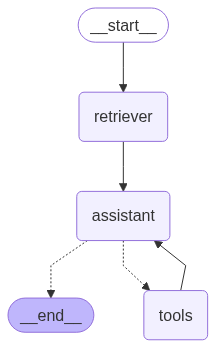

In [82]:
from IPython.display import Image, display
compiled_graph = builder.compile()
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## 24. Testing the Agent on a Real GAIA Sample

In this final section, we validate the full pipeline by testing our agent on a randomly selected question from the **GAIA dataset**. This test simulates the full interaction flow—from ingesting a real-world task, to retrieving contextual documents, invoking tools, and generating a reasoned final response.

### Step-by-Step Breakdown

* **Formatting the Sample**:
  We use a `print_sample` helper function to neatly display all metadata from a GAIA sample, including:

  * Task ID and question level.
  * The natural language **question**.
  * The **annotator's final answer**.
  * Step-by-step reasoning and tools used during the annotation.

* **Selecting the Test Query**:
  A single question is randomly chosen from the dataset using:

  ```python
  sample = random.choice(dataset.to_list())
  ```

* **Invoking the Agent**:
  The selected question is passed to the compiled LangGraph agent, and the total response time is measured with `time.time()`. This simulates a real inference use case:

  ```python
  response = agent.invoke({"messages": [{"type": "user", "content": question}]})
  ```

* **Displaying the Result**:
  The final assistant response is printed along with the runtime duration, so we can assess:

  * The **quality** of the generated answer.
  * Whether the agent invoked the appropriate tools.
  * How closely the output matches the ground truth.

In [83]:
import time

# Function to pretty print the sample
def print_sample(sample):
    line = "─" * 60
    print(line)
    print(f"Task ID     : {sample['task_id']}")
    print(f"Level       : {sample['Level']}")
    print(f"Question    : {sample['Question']}")
    print(f"Answer      : {sample['Final answer']}")
    print("Annotator Metadata:")
    print(" ├── Steps:")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f" │    ├── {step}")
    print(f" ├── Number of steps : {sample['Annotator Metadata']['Number of steps']}")
    print(f" ├── Duration        : {sample['Annotator Metadata']['How long did this take?']}")
    print(f" ├── Tools used:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f" │    ├── {tool}")
    print(f" └── Number of tools : {sample['Annotator Metadata']['Number of tools']}")
    print(line)

# Sample one question from dataset
sample = random.choice(dataset.to_list())

# Show sample details
print_sample(sample)

# Extract the question text
question = sample["Question"]

# Invoke the agent with the question
start = time.time()
response = agent.invoke({
    "messages": [
        {"type": "user", "content": question}
    ]
})
end = time.time()
elapsed = end - start

# Print the agent's response
print("\nAgent's Response:")
print(f"\nAgent's Response (runtime: {elapsed:.2f} seconds):")
print(response['messages'][-1].content)


────────────────────────────────────────────────────────────
Task ID     : 20194330-9976-4043-8632-f8485c6c71b2
Level       : 2
Question    : The YouTube channel Game Grumps began a Let’s Play of the game Sonic the Hedgehog (2006) in the year 2012. Thirty seconds into the first episode, a phrase is shown on the screen in white letters on a red background. How many times does the letter "E" appear in this phrase?
Answer      : 4
Annotator Metadata:
 ├── Steps:
 │    ├── 1. Look up "Game grumps sonic 2006 playthrough".
 │    ├── 2. Click on the first result and verify that it matches the parameters from the question.
 │    ├── 3. Scrub to the thirty-second mark in the video.
 │    ├── 4. Note the letters in white on the red background.
 │    ├── 5. Count the letter "E"'s in the phrase.
 ├── Number of steps : 5
 ├── Duration        : 5 minutes
 ├── Tools used:
 │    ├── 1. Web browser
 │    ├── 2. YouTube player
 │    ├── 3. Color recognition
 │    ├── 4. OCR
 └── Number of tools : 4
────

In [84]:
# Sample one question from dataset
sample = random.choice(dataset.to_list())

# Show sample details
print_sample(sample)

# Extract the question text
question = sample["Question"]

# Invoke the agent with the question
start = time.time()
response = agent.invoke({
    "messages": [
        {"type": "user", "content": question}
    ]
})
end = time.time()
elapsed = end - start

# Print the agent's response
print("\nAgent's Response:")
print(f"\nAgent's Response (runtime: {elapsed:.2f} seconds):")
print(response['messages'][-1].content)


────────────────────────────────────────────────────────────
Task ID     : dd3c7503-f62a-4bd0-9f67-1b63b94194cc
Level       : 2
Question    : Use density measures from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023.

I have a gallon of honey and a gallon of mayonnaise at 25C. I remove one cup of honey at a time from the gallon of honey. How many times will I need to remove a cup to have the honey weigh less than the mayonaise? Assume the containers themselves weigh the same.
Answer      : 6
Annotator Metadata:
 ├── Steps:
 │    ├── 1. Search "LibreText density mayonnaise"
 │    ├── 2. Click result, confirm the correct license.
 │    ├── 3. Search "cm^3 to 1 cup"
 │    ├── 4. Use results with density measures to form the equation (16*236.588)(1.420 - 0.910)/(236.588*1.420)
 │    ├── 5. Round up
 ├── Number of steps : 5
 ├── Duration        : 20 minutes
 ├── Tools used:
 

### What Does This Demonstrate?

This test closes the loop by showing the **end-to-end performance** of the agent on an actual annotation task. In the example shown, the agent:

* Correctly interprets the problem.
* Uses **density values** to calculate the weight of each substance.
* Performs mathematical reasoning with unit conversions and rounding.
* Produces a **concise and correct final answer** (removing 6 cups of honey).

By passing this test case, we verify that the graph structure, toolset, retrieval logic, and LLM behavior work harmoniously to emulate human annotator performance.